# 基于Pytorch的卷积神经网络
## 目标
- 使用pytorch构建卷积神经网络
- 使用MNIST数据集，要求准确率97%以上
- 保存网络
## MNIST数据集

In [11]:
import torch as pt
import torchvision as ptv
import numpy as np
import matplotlib.pyplot as plt

train_set = ptv.datasets.MNIST(
    "../../pytorch_database/mnist/train",
    train=True,transform=ptv.transforms.ToTensor(),
    download=True
)
test_set = ptv.datasets.MNIST(
    "../../pytorch_database/mnist/test",
    train=False,
    transform=ptv.transforms.ToTensor(),
    download=True
)
train_dataset = pt.utils.data.DataLoader(train_set,batch_size=100)
test_dataset = pt.utils.data.DataLoader(test_set,batch_size=100)
display_dataset = pt.utils.data.DataLoader(test_set,batch_size=9)

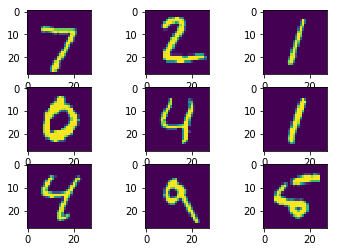

[[7, 2, 1], [0, 4, 1], [4, 9, 5]]


In [28]:
for i in enumerate(display_dataset):
    inputs = pt.autograd.Variable()
    _,(inputs,labels) = i
    break
# print(inputs)
inputs = inputs.numpy()
labels = labels.numpy().reshape((3,3))
# print(inputs.shape,np.max(inputs),np.min(inputs))
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(inputs[i][0])
plt.show()
print(labels.tolist())

## 构建网络模型

In [91]:
class CNN(pt.nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = pt.nn.Conv2d(1,16,3,padding=1)
        self.conv2 = pt.nn.Conv2d(16,32,3,padding=1)
        self.fc1 = pt.nn.Linear(32 * 7 * 7,512)
        self.fc2 = pt.nn.Linear(512,128)
        self.fc3 = pt.nn.Linear(128,10)
        self.pool = pt.nn.MaxPool2d(2)
        
    def forward(self,x):
        x = self.pool(pt.nn.functional.relu(self.conv1(x)))
        x = self.pool(pt.nn.functional.relu(self.conv2(x)))
        x = x.view(-1,7 * 7 * 32)
        x = pt.nn.functional.relu(self.fc1(x))
        x = pt.nn.functional.relu(self.fc2(x))
        return pt.nn.functional.softmax(self.fc3(x))
model = CNN().cuda()
print(model)

CNN (
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear (1568 -> 512)
  (fc2): Linear (512 -> 128)
  (fc3): Linear (128 -> 10)
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
)


## 代价函数与优化器

In [92]:
lossfunc = pt.nn.CrossEntropyLoss().cuda()
optimiter = pt.optim.Adam(model.parameters(),lr=0.001)

def AccuarcyCompute(pred,label):
    pred = pred.cpu().data.numpy()
    label = label.cpu().data.numpy()
    test_np = (np.argmax(pred,1) == label)
    test_np = np.float32(test_np)
    return np.mean(test_np)

## 训练

0 : 0.13
100 : 0.71
200 : 0.66
300 : 0.81
400 : 0.88
500 : 0.96
0 : 0.97
100 : 0.98
200 : 0.91
300 : 0.97
400 : 0.99
500 : 1.0


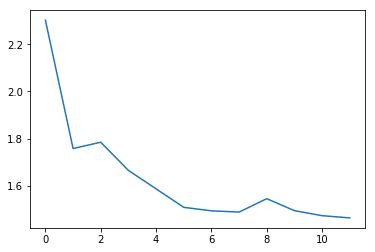

In [93]:
loss_list = []
for _ in range(2):
    for i,(inputs,labels) in enumerate(train_dataset):
        inputs = pt.autograd.Variable(inputs).cuda()
        labels = pt.autograd.Variable(labels).cuda()
        optimiter.zero_grad()
        
        outputs = model(inputs)
        loss = lossfunc(outputs,labels)
        loss.backward()
        
        optimiter.step()
        if i % 100 == 0:
            print(i,":",AccuarcyCompute(outputs,labels))
            loss_list.append(loss.cpu().data.numpy()[0])
#             print(loss_list)
plt.plot(range(len(loss_list)),loss_list)
plt.show()

## 测试

In [94]:
accuarcy_list = []
for i,(inputs,labels) in enumerate(test_dataset):
    inputs = pt.autograd.Variable(inputs).cuda()
    labels = pt.autograd.Variable(labels).cuda()
    outputs = model(inputs)
    accuarcy_list.append(AccuarcyCompute(outputs,labels))
print(sum(accuarcy_list) / len(accuarcy_list))

0.975300005674


## 可视化

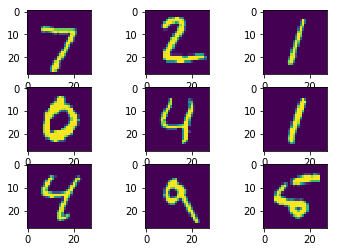

Variable containing:
 7
 2
 1
 0
 4
 1
 4
 9
 5
[torch.cuda.LongTensor of size 9 (GPU 0)]



In [98]:
for i in enumerate(display_dataset):
    inputs = pt.autograd.Variable()
    _,(inputs,labels) = i
    break
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(inputs.numpy()[i][0])
plt.show()
inputs = pt.autograd.Variable(inputs).cuda()
_,outputs = pt.max(model(inputs),1)
print(outputs)

## 保存网络

In [100]:
pt.save(model.state_dict(),'../../pytorch_model/cnn/base_cnn.pt')